# Install Prophet & Dependencies

In [1]:
!pip install Prophet

     |████████████████████████████████| 65 kB 2.0 MB/s 
     |████████████████████████████████| 49 kB 2.2 MB/s 
     |████████████████████████████████| 43 kB 446 kB/s 
  Created wheel for Prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640502 sha256=805a70e7a37c54ce2c680d46ba4f22643dd9651b4c2437d127cb216690d98ef6
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built Prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
# Import Dependencies
import pandas as pd
from prophet import Prophet
import psycopg2
import sqlalchemy


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Connect to DB
connection = psycopg2.connect(
    host = 'teamev.c5ap8dqhexya.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = 'dogecoin',
    database='postgres'
    )
cursor=connection.cursor()

sql = """
SELECT * FROM maclea; 
"""

df = pd.read_sql(sql, con=connection)
df.head(10)

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations,elecv_totals,hybrid_totals
0,2012-01-01,1257.0,0.128,3.380,4,4,2057.0,652.0,605.0
1,2012-02-01,1566.0,0.128,3.579,4,4,2130.0,522.0,1044.0
2,2012-03-01,3815.0,0.127,3.852,4,4,2213.0,635.0,3180.0
3,2012-04-01,3565.0,0.127,3.900,4,4,2273.0,449.0,3116.0
4,2012-05-01,3367.0,0.129,3.732,5,5,2367.0,595.0,2772.0
5,2012-06-01,2524.0,0.135,3.539,6,6,2439.0,580.0,1944.0
6,2012-07-01,3029.0,0.133,3.439,7,7,2497.0,454.0,2575.0
7,2012-08-01,4686.0,0.133,3.722,7,7,2550.0,774.0,3912.0
8,2012-09-01,5745.0,0.133,3.849,8,7,2576.0,1183.0,4562.0
9,2012-10-01,7084.0,0.128,3.746,9,7,2771.0,1972.0,5112.0


In [4]:
df.dtypes

month              object
total_ev          float64
elec_price        float64
gas_price         float64
model_id_count      int64
brand_id_count      int64
ev_stations       float64
elecv_totals      float64
hybrid_totals     float64
dtype: object

# Prepare Data for ML Model Training

In [5]:
# Change 'month' datatype to date
df['month']= pd.to_datetime(df['month'])
df = df.sort_values(by=['month'])
df['month'] = df['month'].apply(lambda x: x.strftime("%Y-%m-%d"))
df

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations,elecv_totals,hybrid_totals
0,2012-01-01,1257.0,0.128,3.380,4,4,2057.0,652.0,605.0
1,2012-02-01,1566.0,0.128,3.579,4,4,2130.0,522.0,1044.0
2,2012-03-01,3815.0,0.127,3.852,4,4,2213.0,635.0,3180.0
3,2012-04-01,3565.0,0.127,3.900,4,4,2273.0,449.0,3116.0
4,2012-05-01,3367.0,0.129,3.732,5,5,2367.0,595.0,2772.0
...,...,...,...,...,...,...,...,...,...
91,2019-08-01,26455.0,0.139,2.621,40,22,15982.0,19522.0,6933.0
92,2019-09-01,31833.0,0.139,2.592,39,22,16600.0,26422.0,5411.0
93,2019-10-01,8665.0,0.136,2.627,32,16,16926.0,3509.0,5156.0
94,2019-11-01,10180.0,0.133,2.598,30,15,17280.0,4307.0,5873.0


In [38]:
# Create dataframe for Date & Monthly Sales columns and rename as 'ds' and 'y'
dfpredict = pd.DataFrame(df,columns = ['month','total_ev'])
dfpredict.rename(columns={"month": "ds", "total_ev": "y"}, inplace=True)

dfpredict['cap'] = 60000
dfpredict['floor'] = 0
dfpredict.head()

,ds,y,cap,floor
0,2012-01-01,1257.0,60000,0
1,2012-02-01,1566.0,60000,0
2,2012-03-01,3815.0,60000,0
3,2012-04-01,3565.0,60000,0
4,2012-05-01,3367.0,60000,0


# Train Model

In [61]:
# Confidence Interval = 95%, Growth = Logistic; Seasonality = Quarterly, Trend changepoints = Custom
m = Prophet(interval_width=0.95,growth='logistic',yearly_seasonality = 4,changepoints=['2018-08-01','2019-01-01'])
m.fit(dfpredict)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forecast using Trained model

distributed.nanny - WARNING - Restarting worker


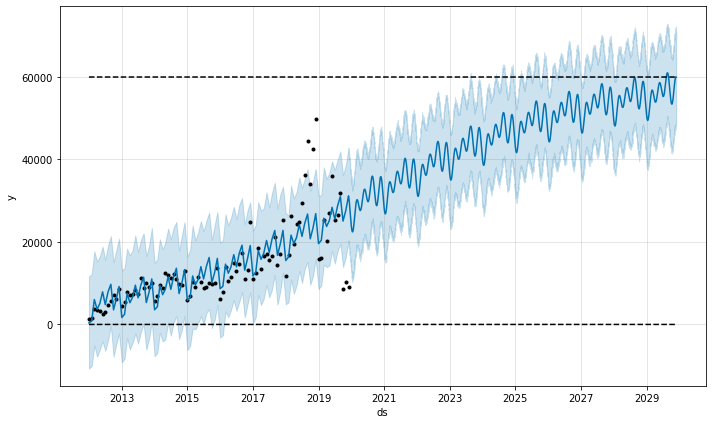

In [62]:
# Set floor and cap accordingly for logistic growth modeling
future = m.make_future_dataframe(periods=3650)
future['cap'] = 60000
future['floor'] = 0
fcst = m.predict(future)
fig = m.plot(fcst)

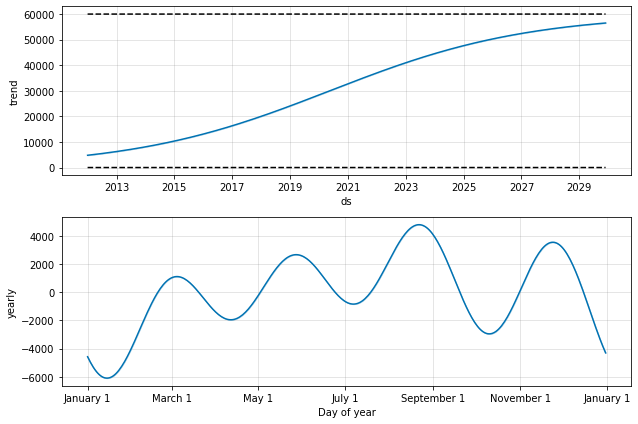

In [63]:
# Plot each trend component from the trained model
fig2 = m.plot_components(fcst)


# Check model error

In [68]:
# Cross validate using historical data and forecast using selected days
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')



INFO:prophet:Making 10 forecasts with cutoffs between 2014-06-25 00:00:00 and 2018-12-01 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [69]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-07-01,11236.255158,8999.306783,13402.663894,11242.0,2014-06-25
1,2014-08-01,13307.475085,11025.398406,15492.221524,12172.0,2014-06-25
2,2014-09-01,14531.401141,12559.910284,16615.706762,10921.0,2014-06-25
3,2014-10-01,13785.708705,11484.525865,15984.505797,9739.0,2014-06-25
4,2014-11-01,15225.280621,13153.687842,17398.489046,9646.0,2014-06-25


In [70]:
# Display performance metrics 
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,41 days,2.259701e+07,4753.631358,3451.149882,0.310692,0.316339,0.257962,0.500000
1,42 days,2.461329e+07,4961.178734,3860.578258,0.356337,0.333826,0.293777,0.416667
2,46 days,2.326250e+07,4823.121889,3649.399075,0.315476,0.316339,0.267246,0.500000
3,48 days,2.260733e+07,4754.716654,3491.894065,0.293797,0.275959,0.249900,0.583333
4,52 days,2.169276e+07,4657.548737,3252.754994,0.252103,0.171120,0.217801,0.666667


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


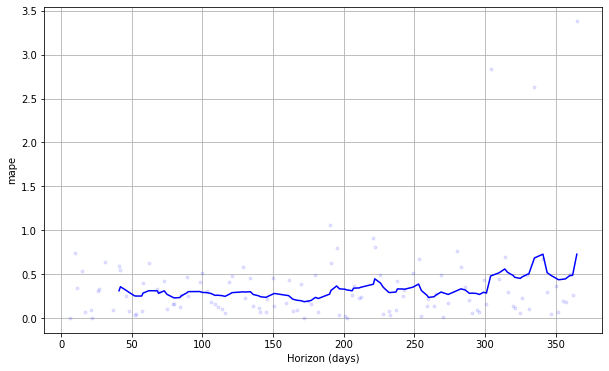

In [71]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
